# Physics-Informed Unsupervised Representation Learning for Pixel Observations of Dynamic Systems
Jan Tiegges

Abstract too follow...

In [58]:
import torch
from os import path
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Image
import cv2 as cv
import numpy as np
import math

import matplotlib.image as mpimg

from utils import figures
from utils.helper import convert_data, read_config
from utils.file_manager import load_model, pickle_save
from data_tmp import get_dataset


THIS_DIR = path.dirname(path.abspath("evaluate.ipynb"))
DATA_DIR = path.join(THIS_DIR, "saved_data")
MODEL_DIR = path.join(THIS_DIR, "saved_models")
FIG_DIR = path.join(THIS_DIR, "figures")
DATA_CONFIG_DIR = path.abspath(path.join(THIS_DIR, 'config/data_config.yaml'))


## 1. Create/Load data

Successfully loaded saved_data from path /Users/jantiegges/Google Drive/Bachelorarbeit/BA/saved_data/pendulum_1000_100_64_3_1.pkl

Example of training data


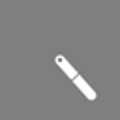

In [2]:
# load data config file
data_config = read_config(DATA_CONFIG_DIR)

# properties of dataset (to specify in data_conifg.yaml)
system = data_config['system']
ep = data_config['episodes']
ts = data_config['timesteps']
im_size = data_config['im_size']
seq_len = data_config['seq_len']
channels = data_config['channels']
latent_dim = data_config['latent_dim']

# load dataset
# if dataset doesn't exist yet, it will be constructed from the OpenAI Gym environment
filename = f"{system}_{ep}_{ts}_{im_size}_{seq_len}_{channels}"
data, data_config = get_dataset(data_config, system, DATA_DIR, filename, seed=32)
# convert data to fit input shape for PixelDDN
trainset, testset = convert_data(data)

# takes frames of first episode
frames = data['train_data'][0,:,0,:,:,0]

# creates and saves gif
path = "./figures"
gifname = figures.make_gif(frames, path, filename, duration=1e-1, pixels=[120, 120])

print("\nExample of training data")
Image(filename=gifname, width=200)

## 2. Load models 

One can choose three out of the models shown below in order to compare them

|	|   Multilayer-Perceptron   |   Lagrangian Neural Network   |   Hamiltonian Neural Network   | 
| ------------- |:------------:| :------------:| :------------:|
| Autoencoder | MLP_AE | LNN_AE | HNN_AE |
| Variational Autoencoder | MLP_VAE| LNN_VAE | HNN_VAE |
| Convolutional Autoencoder | MLP_CAE | LNN_CAE | HNN_CAE |
| Convolutional Variational Autoencoder | MLP_CVAE | LNN_CVAE | HNN_CVAE |

In [68]:
# choose models to compare

model1_name = "LNN_CVAE"
model2_name = "LNN_CVAE"
model3_name = "LNN_CVAE"

In [69]:
# load saved model parameters
path = f"{MODEL_DIR}/{model1_name}"
model1 = load_model(model1_name, data_config, path)

path = f"{MODEL_DIR}/{model2_name}"
model2 = load_model(model2_name, data_config, path)

path = f"{MODEL_DIR}/{model3_name}"
model3 = load_model(model3_name, data_config, path)

## 3. Training/Testing

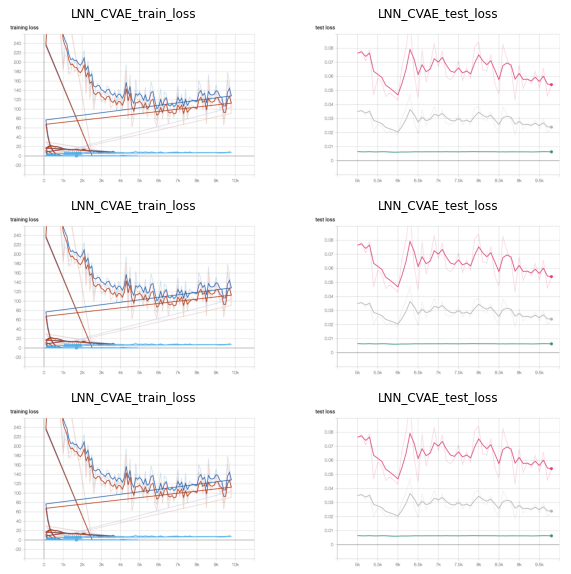

In [70]:
# show figures of training and testing of the models (saved in figures)

# set filenames
filenames = []
filenames.append(f"{FIG_DIR}/{model1_name}_train_loss.png")
filenames.append(f"{FIG_DIR}/{model1_name}_test_loss.png")
filenames.append(f"{FIG_DIR}/{model2_name}_train_loss.png")
filenames.append(f"{FIG_DIR}/{model2_name}_test_loss.png")
filenames.append(f"{FIG_DIR}/{model3_name}_train_loss.png")
filenames.append(f"{FIG_DIR}/{model3_name}_test_loss.png")

fig = plt.figure(figsize=(10,10))
ax = []

path_len = len(FIG_DIR)+1

# plot figures
for i, filename in enumerate(filenames):
    ax.append(fig.add_subplot(3,2,i+1))
    title = filename[path_len:-4]
    ax[-1].set_title(f"{title}")
    img = plt.imread(filename)
    plt.axis('off')
    plt.imshow(img)

## 4. Autoencoder

### 4.1 Input Sequences

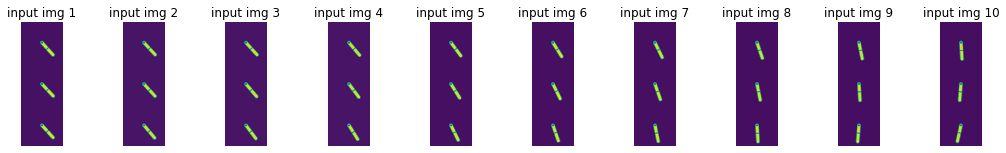

In [71]:
# choose random input images
input_img = data['train_data'][0,:10,:seq_len,...]

fig = plt.figure(figsize=(18,5))
ax = []
input_len = input_img.shape[0]
idx = 1

# plot input images
for i in range(input_len):
    ax.append(fig.add_subplot(2,input_len,idx))
    ax[-1].set_title(f"input img {i+1}")
    img = input_img[i,:seq_len,...].reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1

### 4.2 Reconstruction of Autoencoder from input images

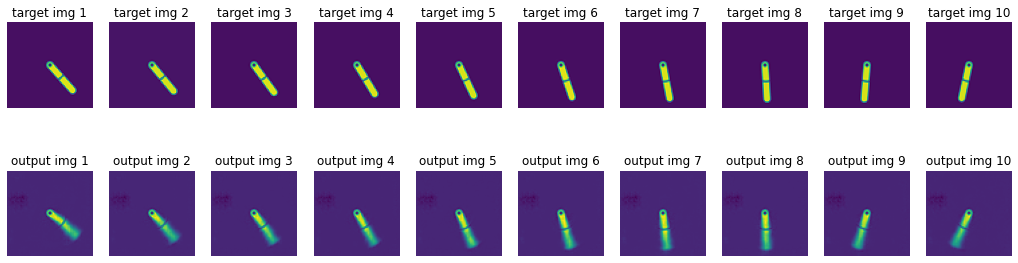

In [72]:
# convert numpy to tensor
batch = torch.tensor(input_img)

# concat along channel dimension
b, s, h, w, c = batch.size()

# if convolutional
if 'C' in model1_name:
    batch = batch.reshape(b, s * c, h, w)
else:
    batch = batch.reshape(b, s * c * h * w)

# forward input through autoencoder
x_hat = model1.ae(batch)

fig = plt.figure(figsize=(18,5))
ax = []
input_len = batch.shape[0]
idx = 1

# plot target images
# the target image is always the last image of the input sequence
for i in range(input_len):
    ax.append(fig.add_subplot(2,input_len,idx))
    ax[-1].set_title(f"target img {i+1}")
    img = batch[i,-1,...].numpy().reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1
    
# plot predicted images
for i in range(input_len):
    ax.append(fig.add_subplot(2,input_len,idx))
    ax[-1].set_title(f"output img {i+1}")
    img = x_hat[i,...].detach().numpy().reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1

PROBLEM: Autoencoder predicts already and not only encodes

### 4.3 Reconstruction of Autoencoder from position parameter

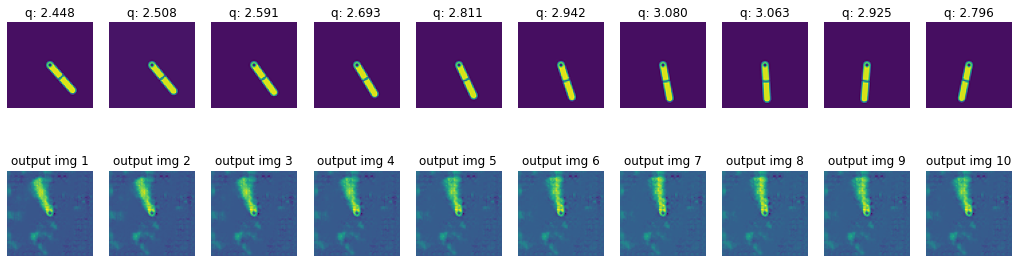

In [73]:
# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'L' in model1_name:
    coords_in = data['train_meta_data']['gcoords_in'][0,:10]
elif 'H' in model1_name:
    coords_in = data['train_meta_data']['ccoords_in'][0,:10]
else:
    # choose canonical or generalized coordinates for MLP network?
    coords_in = data['train_meta_data']['ccoords_in'][0,:10]
    
q = coords_in[:, :int(latent_dim / 2)]

# optional position parameters for distinctive positions
#q = np.array([[0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi, 5*math.pi/4, 3*math.pi/2, 7*math.pi/4, 2*math.pi, -math.pi],])
#q.resize((q.shape[1],1))

q_tens = torch.tensor(q)

x_hat = model1.ae.decode(q_tens.float())

fig = plt.figure(figsize=(18,5))
ax = []
input_len = batch.shape[0]
idx = 1

# plot figures
for i in range(input_len):
    ax.append(fig.add_subplot(2,input_len,idx))
    ax[-1].set_title(f"q: {q[i][0]:.3f}")
    img = batch[i,-1,...].numpy().reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1
    
for i in range(input_len):
    ax.append(fig.add_subplot(2,input_len,idx))
    ax[-1].set_title(f"output img {i+1}")
    img = x_hat[i,...].detach().numpy().reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1

So we see that the construction from the actual dynamic position parameter unfortunately doesn't work. Let's take a look at the encoded dynamic position parameter vs the actual ones, to get an idea why.

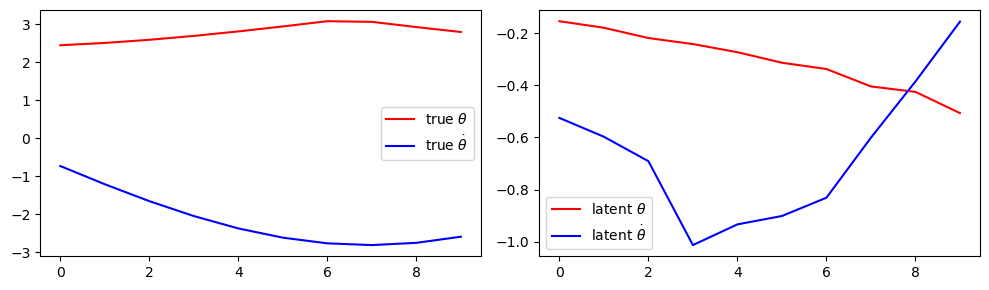

In [74]:
# compare encoded dynamic parameters with actual ones

x = data['train_data'][0,:10,:seq_len,...]
# convert numpy to tensor
batch = torch.tensor(x)

# concat along channel dimension
b, s, h, w, c = batch.size()

# if convolutional
if 'C' in model1_name:
    batch = batch.reshape(b, s * c, h, w)
else:
    batch = batch.reshape(b, s * c * h * w)
    
if 'V' in model1_name:
    mu, log = model1.ae.encode(batch)
    z_latent = model1.ae.reparameterize(mu, log).detach().numpy()
else:
    z_latent = model1.ae.encode(batch).detach().numpy()
    
# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'LNN' in model1_name:
    z_actual = data['train_meta_data']['gcoords_in'][0,:10]
elif 'HNN' in model1_name:
    z_actual = data['train_meta_data']['ccoords_in'][0,:10]
else: # MLP
    # choose canonical or generalized coordinates for MLP network?
    z_actual = data['train_meta_data']['ccoords_in'][0,:10]
    
fig = plt.figure(figsize=[10,3], dpi=100)
plt.subplot(1,2,1)
plt.plot(z_actual[:,0], "r-", label='true $\\theta$')
plt.plot(z_actual[:,1], "b-", label='true $\dot \\theta$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(z_latent[:,0], "r-", label='latent $\\theta$') 
plt.plot(z_latent[:,1], "b-", label='latent $\dot \\theta$')
plt.legend()

plt.tight_layout() ; plt.show()

Looks off! Let's see if the network is able to imitate the general structure of the latent space in the next section

LNN_CVAE:

    latent position: roughly stays at the same level with light downward trend
    latent velocity: the curve decreases to the value 2 and then increases linearly
HNN_CVAE:

MLP_CVAE:


LNN_CAE:

HNN_CAE:
   
   latent position: stays stable, but always around zero
   
   latent momentum: sinks and then rises again at turning point around 5, but starts way too high though
   
MLP_CAE:

    latent position: stays stable, but negative value
    
    latent velocity/momentum: completely lost

## 5. Latent Space

In this section we will look at the general structure of the latent space

### 5.1 Dynamic Parameters of Input Sequence (last input image)

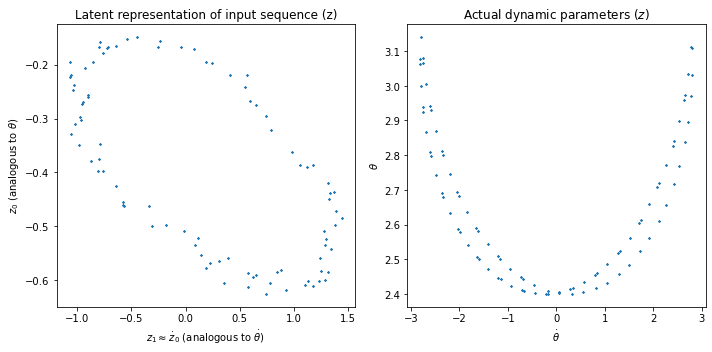

In [75]:
# show structure of latent space

x = data['train_data'][0,:,:seq_len,...]
# convert numpy to tensor
batch = torch.tensor(x)

# concat along channel dimension
b, s, h, w, c = batch.size()

# if convolutional
if 'C' in model1_name:
    batch = batch.reshape(b, s * c, h, w)
else:
    batch = batch.reshape(b, s * c * h * w)
    
if 'V' in model1_name:
    mu, log = model1.ae.encode(batch)
    z_latent = model1.ae.reparameterize(mu, log).detach().numpy()
else:
    z_latent = model1.ae.encode(batch).detach().numpy()

# get generalized or canononical coordinates of input dependng if Lagrangian or Hamiltonian
if 'LNN' in model1_name:
    z_actual = data['train_meta_data']['gcoords_in'][0,:]
elif 'HNN' in model1_name:
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
else:
    # choose canonical or generalized coordinates for MLP network?
    z_actual = data['train_meta_data']['ccoords_in'][0,:]
    
fig = plt.figure(figsize=(10, 5), facecolor='white')

ax1 = fig.add_subplot(1, 2, 1, frameon=True)
plt.plot(z_latent[:,1], z_latent[:,0],'*', markersize=2)
ax1.set_xlabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
ax1.set_ylabel("$z_0$ (analogous to $\\theta$)")
plt.title("Latent representation of input sequence (z)")

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(z_actual[:,1], z_actual[:,0], '*', markersize=2)
ax2.set_xlabel("$\dot \\theta$")
ax2.set_ylabel("$\\theta$")
plt.title("Actual dynamic parameters ($z$)")

plt.tight_layout() ; plt.show()

proportions of y-axis are similiar

Hier Vergleich zwischen den verschiedenen Netzen passend

Vergleich ersten 8 Schritte (pred len im Training) vs gesamte Spanne
--> perfectly captures structure for pred len im Training

(90,)


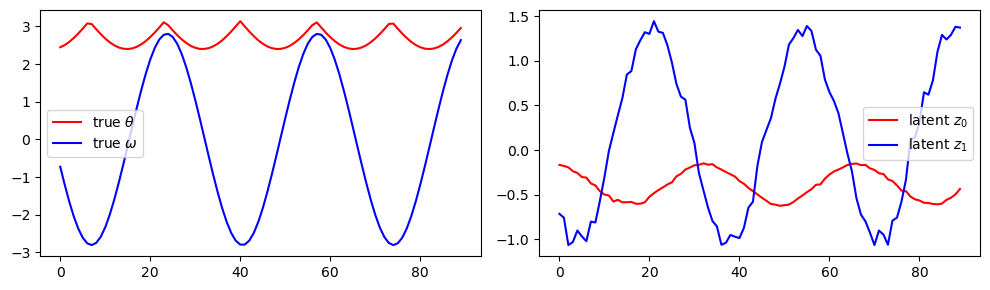

In [76]:
fig = plt.figure(figsize=[10,3], dpi=100)
plt.subplot(1,2,1)
plt.plot(z_actual[:,0], "r-", label='true $\\theta$')
plt.plot(z_actual[:,1], "b-", label='true $\omega$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(z_latent[:,0], "r-", label='latent $z_0$') 
plt.plot(z_latent[:,1], "b-", label='latent $z_1$')
plt.legend()

print(z_latent[:,0].shape)

plt.tight_layout() ; plt.show()

This actually looks pretty similar:

- position is never negative ans oscillates between zero and some value
- velocity oscillates between positive and negative values
- position and velocity roughly have their extreme points at the same time

LNN_CVAE:

    latent position: the general course of the curve is very similar to the real position data, but the intervals are longer
    latent velocity: The curve is very similiar, only the values are completely different.

HNN_CVAE:

MLP_CVAE:


LNN_CAE:

HNN_CAE:
   
   latent position: stays stable, but always around zero
   
   latent momentum: sinks and then rises again at turning point around 5, but starts way too high though
   
MLP_CAE:

    latent position: intervalls are way too long
    
    latent velocity/momentum: general trajectory looks pretty accurate but the curved is shifted 

### 5.2 Dynamic Parameters of predicted images

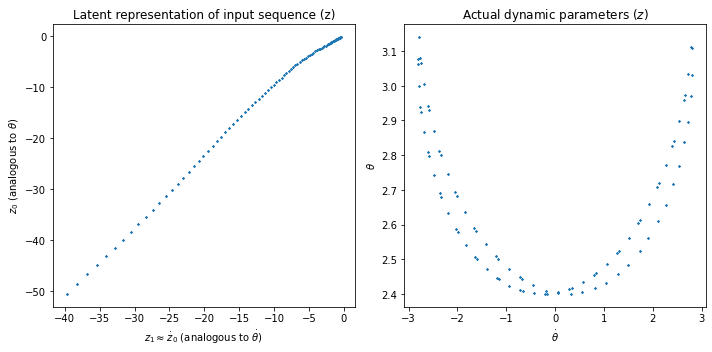

In [86]:
# predict input images for some timesteps and compare to actual ones
input_img = trainset[0,:seq_len,...]

input_img = np.expand_dims(input_img, axis=0)

# convert numpy to tensor
batch = torch.tensor(input_img)

# set number of desired predicted time steps
pred_steps = 89

pred = model1(batch, pred_steps, variational=True, convolutional=True)
if 'L' in model1_name:
    pred_z0 = np.array(pred.q)#[:,-1,-1]
    pred_z1 = np.array(pred.qdot)
elif 'H' in model1_name:
    pred_z0 = np.array(pred.q)#[:,-1,-1]
    pred_z1 = np.array(pred.p)
    
fig = plt.figure(figsize=(10, 5), facecolor='white')

ax1 = fig.add_subplot(1, 2, 1)
plt.plot(pred_z1, pred_z0, '*', markersize=2)
ax1.set_xlabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
ax1.set_ylabel("$z_0$ (analogous to $\\theta$)")
plt.title("Latent representation of input sequence (z)")

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(z_actual[:,1], z_actual[:,0], '*', markersize=2)
ax2.set_xlabel("$\dot \\theta$")
ax2.set_ylabel("$\\theta$")
plt.title("Actual dynamic parameters ($z$)")

plt.tight_layout() ; plt.show()

### 5.3 Look at encoded Acceleration

torch.Size([90, 3, 64, 64, 1])


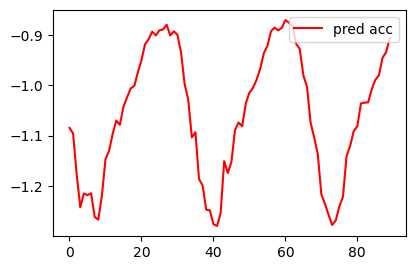

In [87]:
if 'LNN' in model1_name:
    
    x = data['train_data'][0,:,:seq_len,...]
    # convert numpy to tensor
    batch = torch.tensor(x)
    
    # concat along channel dimension
    b, s, h, w, c = batch.size()
    print(batch.size())

    # if convolutional
    if 'C' in model1_name:
        batch = batch.reshape(b, s * c, h, w)
    else:
        batch = batch.reshape(b, s * c * h * w)
    
    if 'V' in model1_name:
        testmu, testlog = model1.ae.encode(batch)
        testz = model1.ae.reparameterize(testmu, testlog)
    else:
        testz = model1.ae.encode(batch)

    testq, testqdot = model1.ddn.to_config_space(testz)
    testxhat = model1.ae.decode(testq)
    

    q_dott = model1.ddn(testq, testqdot)
    #print(testq, testqdot)

    testq, testqdot = model1.integrator.step(x1=testq, x2=testqdot, ddn=model1.ddn, hamiltonian=False)
    q_dott = model1.ddn(testq, testqdot)
    #print(testq, testqdot)
    #print(q_dott)
    
    fig = plt.figure(figsize=[10,3], dpi=100)
    plt.subplot(1,2,1)
    plt.plot(q_dott[:].detach().numpy(), "r-", label='pred acc')
    #plt.plot(z_actual[:,1], "b-", label='true $\omega$')
    plt.legend()

## 6. Hamiltonian / Lagrangian

In this section we will look at the encoded Hamiltonian (total energy) and Lagrangian of the model. 

### 6.1 Encoded Hamiltonian / Lagrangian

First we will take a look at the encoded value. Since the Hamiltonian represents the total energy (kinetic + potential energy) it should stay at the same level. The Lagrangian represents the difference between kinetic and potential energy, which is why it should oscillate.

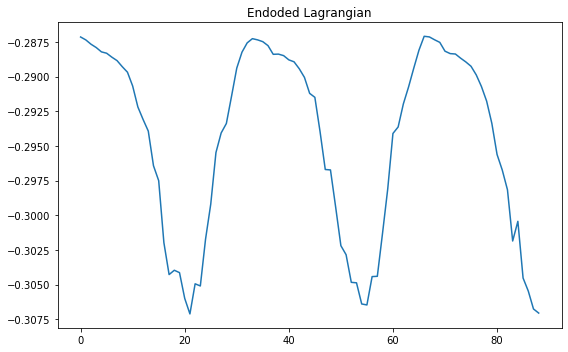

In [79]:
# choose random input images
input_img = data['train_data'][0,:89,:seq_len,...]

# convert numpy to tensor
batch = torch.tensor(input_img)
batch = batch.permute(0, 1, 4, 2, 3)

# concat along channel dimension
b, s, h, w, c = batch.size()
    
energies = []

#input_img = np.expand_dims(input_img, axis=0)

pred = model1(batch, 0, variational=True, convolutional=True)
energies = np.array(pred.energies)[-1,:,-1]


fig = plt.figure(figsize=[8,5])

plt.plot(energies)
if 'LNN' in model1_name:
    plt.title("Endoded Lagrangian")
elif 'HNN' in model1_name:
    plt.title("Encoded Hamiltonian (total energy)")
    
plt.tight_layout() ; plt.show()

HNN_CAE: - energy level oscillates and is not stable

LNN_CVAE: 
    - Lagrangian oscillates

### 6.2 Predicted Hamiltonian / Lagrangian

Now we will take a look at the predicted value. 

(90, 1, 1)


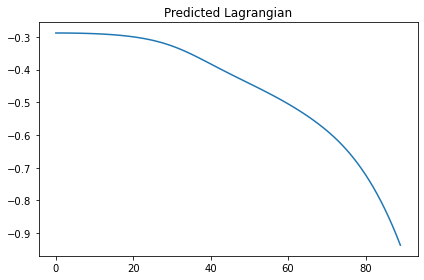

In [80]:
# show level of Hamiltonian (energy) and Lagrangian which is supposed to stay at the same level
# compare conserving qualities
# maybe talk about adding energy in order to simulate non-conserving systems


# predict input images for some timesteps and compare to actual ones
input_img = trainset[0,:seq_len,...]

input_img = np.expand_dims(input_img, axis=0)

# convert numpy to tensor
batch = torch.tensor(input_img)

# set number of desired predicted time steps
pred_steps = 89

pred = model1(batch, pred_steps, variational=True, convolutional=True)

pred_energy = np.array(pred.energies)[:,-1,-1]
print(np.array(pred.energies).shape)
plt.plot(pred_energy)
if 'LNN' in model1_name:
    plt.title("Predicted Lagrangian")
elif 'HNN' in model1_name:
    plt.title("Predicted Hamiltonain (total energy)")
    
plt.tight_layout() ; plt.show()
#fig.savefig('{}/total-energy.{}'.format(args.fig_dir, FORMAT))

HNN_CAE: - strangely the energy level is constantly rising

LNN_CVAE: - from timestep 20 onwards, the Lagrangian is staying at the same level

## 7. Prediction

Finally we will take a look at the predictive capabilities of the model

torch.Size([1, 8, 1, 64, 64])


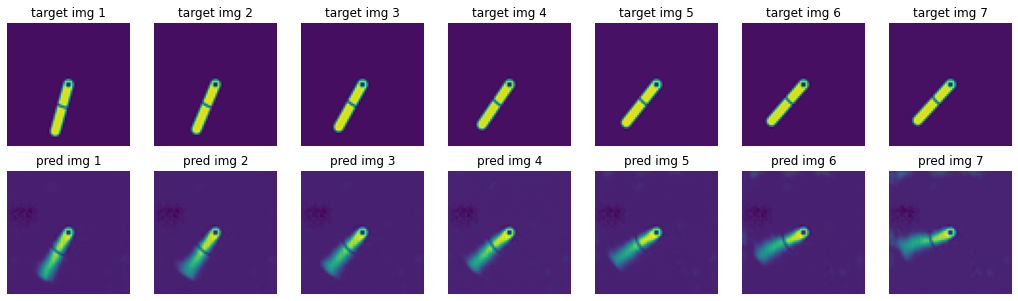

In [81]:
# predict input images for some timesteps and compare to actual ones
input_img = trainset[42,:seq_len,...]
target_img = trainset[42,seq_len:,...]

input_img = np.expand_dims(input_img, axis=0)

# convert numpy to tensor
batch = torch.tensor(input_img)

pred_steps = 7

pred = model1(batch, pred_steps, variational=True, convolutional=True)
    
pred_img = pred.reconstruction

fig = plt.figure(figsize=(18,5))
ax = []
idx = 1

# plot figures
for i in range(pred_steps):
    ax.append(fig.add_subplot(2,pred_steps,idx))
    ax[-1].set_title(f"target img {i+1}")
    img = target_img[i,-1,...].numpy().reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1

for i in range(pred_steps):
    ax.append(fig.add_subplot(2,pred_steps,idx))
    ax[-1].set_title(f"pred img {i+1}")
    img = pred_img[0,i+1,...].detach().numpy().reshape(-1, im_size)
    plt.axis('off')
    plt.imshow(img)
    idx += 1
    
print(pred_img.shape)

This doesn't look so bad! Let's try to make a video with a prediction:

LNN_CVAE: Looks good!


Predicted Video


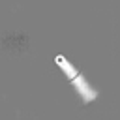

In [82]:
# predict input images for some timesteps and compare to actual ones
input_img = trainset[0,:seq_len,...]
target_img = trainset[0,seq_len:,...]

input_img = np.expand_dims(input_img, axis=0)

# convert numpy to tensor
batch = torch.tensor(input_img)

# set number of desired predicted time steps
pred_steps = 200

pred = model1(batch, pred_steps, variational=True, convolutional=True)
    
pred_img = pred.reconstruction.detach().numpy()

pred_img = pred_img[0,:,-1,...]

# creates and saves gif
path = "./figures"
filename = "pred_video"
gifname = figures.make_gif(pred_img, path, filename, duration=1e-1, pixels=[120, 120])

print("\nPredicted Video")
Image(filename=gifname, width=200)

HNN_CAE: - seems like it captures the general dynamics


MLP_CAE: - doesn't conserve energy at all and stops prediction after 7 timesteps, which was the number of timesteps to predict while training the model 


Example of training data


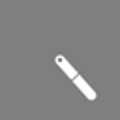

In [83]:
# takes frames of first episode
frames = data['train_data'][0,:,0,:,:,0]

# creates and saves gif
path = "./figures"
gifname = figures.make_gif(frames, path, filename, duration=1e-1, pixels=[120, 120])

print("\nExample of training data")
Image(filename=gifname, width=200)